In [1]:
# conda create --name rcrc-env python=3.11.4 numpy scipy matplotlib pyserial control ipykernel

import time
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import scipy as sp
from SerialStream import SerialStream


def estimate_frf_and_coherence(x, y, fs, window, nperseg, noverlap):
    # Estimate cross spectral density and power spectral densities
    _, Pxy = sp.signal.csd(x, y, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, return_onesided=False)
    _, Pxx = sp.signal.csd(x, x, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, return_onesided=False)
    _, Pyy = sp.signal.csd(y, y, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, return_onesided=False)

    # Calculate frequency
    freq = np.arange(len(Pxy)) / len(Pxy) * fs  # same as freq = np.linspace(0, len(Pxy)-1, len(Pxy)) / len(Pxy) * fs

    # Calculate frequency response function
    g = Pxy / Pxx

    # Calculate coherence
    c = np.abs(Pxy) ** 2 / (Pxx * Pyy)
    return freq, g, c


def get_step_resp_from_frd(G_frd, f_max_hz):
    # Extract complex frequency response
    g = G_frd.magnitude.flatten() * np.exp(1j * G_frd.phase.flatten())
    if np.isnan(np.abs(g[0])):  # TODO: interpolate based on point 2 and 3
        g[0] = g[1]

    # Get frequency vector (rad/s -> Hz)
    freq = G_frd.frequency / (2 * np.pi)

    # Set frequencies above f_max_hz to zero
    df = freq[1] - freq[0]
    ind = (freq >= f_max_hz) & (freq <= freq[-1] - f_max_hz + df)
    g[ind] = 0

    # Step response is cumulative sum of real part of IFFT
    step_resp = np.cumsum(np.real(np.fft.ifft(g)))

    return step_resp

In [2]:
port = "/dev/ttyUSB0"
baudrate = int(2e6)

# Initialize the SerialStream object
try:
    serialStream.reset()
    print("Resetting existing serialStream object.")
except Exception as e:
    serialStream = SerialStream(port, baudrate)
    print("Creating new serialStream object.")

# Starting the stream
serialStream.start()
while serialStream.is_busy_flag():
    time.sleep(0.1)

# Accessing the data
try:
    data = serialStream.get_data()
except Exception as e:
    print("Data Stream not triggered.")
    exit()

# Save the data
filename = "data_00.npz"
np.savez(filename, **data)

# Load the data
loaded = np.load(filename)
data = {"time": loaded["time"], "values": loaded["values"]}

Creating new serialStream object.
SerialStream waiting for 3.00 seconds...
SerialStream started, logging 5 signals
             logging for 2.00 seconds...
             logging for 4.00 seconds...
             logging for 6.00 seconds...
             logging for 8.00 seconds...
             logging for 10.00 seconds...
             logging for 12.00 seconds...
             logging for 14.00 seconds...
             logging for 16.00 seconds...
             logging for 18.00 seconds...
             logging for 20.00 seconds...
SerialStream ended with 0.30 seconds timeout
             logged for 20.00 seconds
             measured 200005 datapoints


(0.0, 697.1999999993983)

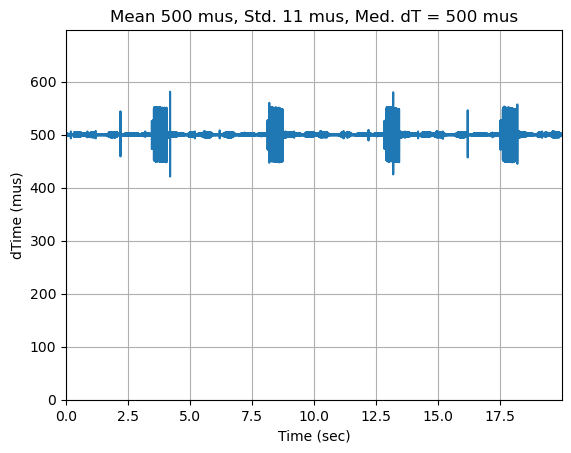

In [3]:
# Evaluate time

Ts = np.mean(np.diff(data["time"]))

plt.figure(1)
plt.plot(data["time"][:-1], np.diff(data["time"]) * 1e6)
plt.grid(True)
plt.title(f"Mean {np.mean(np.diff(data['time']) * 1e6):.0f} mus, " f"Std. {np.std(np.diff(data['time']) * 1e6):.0f} mus, " f"Med. dT = {np.median(np.diff(data['time']) * 1e6):.0f} mus")
plt.xlabel("Time (sec)")
plt.ylabel("dTime (mus)")
plt.xlim([0, data["time"][-2]])
plt.ylim([0, 1.2 * np.max(np.diff(data["time"]) * 1e6)])

Text(0, 0.5, 'Magnitude (dB)')

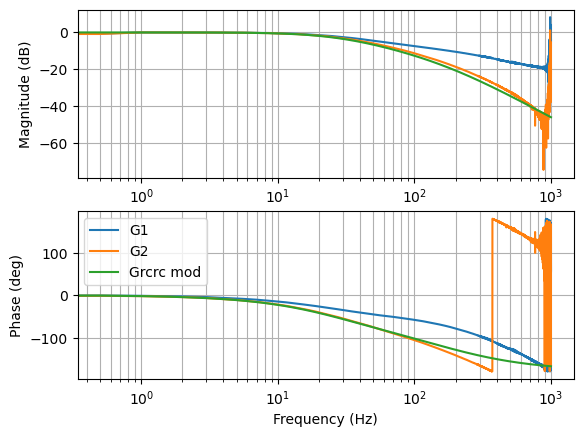

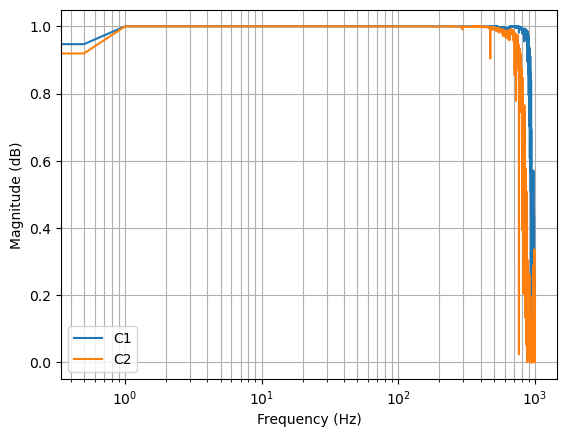

In [4]:
# Evaluate the data

# Defining the indices for the data columns
ind = {}
ind["u_e"] = 0
ind["u_c1"] = 1
ind["u_c2"] = 2
ind["sinarg"] = 3

# Parameters
R1 = 4.7e3  # Ohm
R2 = R1
C1 = 470e-9  # F
C2 = C1

a = R1 * R2 * C1 * C2
b = R1 * C1 + R1 * C2 + R2 * C2

# Transfer function
s = ct.tf([1, 0], 1)
G_rcrc_mod = 1 / (a * s**2 + b * s + 1)

# Frequency response estimation
N_est = round(2.0 / Ts)
k_overlap = 0.5
N_overlap = round(k_overlap * N_est)
window = sp.signal.windows.hann(N_est)

inp = np.diff(data["values"][:, ind["u_e"]])
out = np.diff(data["values"][:, ind["u_c1"]])
freq, g, c = estimate_frf_and_coherence(inp, out, fs=1 / Ts, window=window, nperseg=N_est, noverlap=N_overlap)
G1 = ct.frd(g, 2 * np.pi * freq)
C1 = ct.frd(c, 2 * np.pi * freq)

inp = np.diff(data["values"][:, ind["u_e"]])
out = np.diff(data["values"][:, ind["u_c2"]])
freq, g, c = estimate_frf_and_coherence(inp, out, fs=1 / Ts, window=window, nperseg=N_est, noverlap=N_overlap)
G2 = ct.frd(g, 2 * np.pi * freq)
C2 = ct.frd(c, 2 * np.pi * freq)

mag_G1, phase_G1, _ = ct.frequency_response(G1, 2 * np.pi * freq)
mag_G2, phase_G2, _ = ct.frequency_response(G2, 2 * np.pi * freq)
mag_Grcrc, phase_Grcrc, _ = ct.frequency_response(G_rcrc_mod, 2 * np.pi * freq)

# only show frequencies below Nyquist frequency
ind = freq < 1 / (2 * Ts)

plt.figure(2)
plt.subplot(2, 1, 1)
plt.semilogx(freq[ind], 20 * np.log10(mag_G1.flatten()[ind]), label="G1")
plt.semilogx(freq[ind], 20 * np.log10(mag_G2.flatten()[ind]), label="G2")
plt.semilogx(freq[ind], 20 * np.log10(mag_Grcrc.flatten()[ind]), label="Grcrc mod")
plt.grid(True, which="both", axis="both")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.subplot(2, 1, 2)
plt.semilogx(freq[ind], 180 / np.pi * np.arctan2(np.sin(phase_G1.flatten()[ind]), np.cos(phase_G1.flatten()[ind])), label="G1")
plt.semilogx(freq[ind], 180 / np.pi * np.arctan2(np.sin(phase_G2.flatten()[ind]), np.cos(phase_G2.flatten()[ind])), label="G2")
plt.semilogx(freq[ind], 180 / np.pi * np.arctan2(np.sin(phase_Grcrc.flatten()[ind]), np.cos(phase_Grcrc.flatten()[ind])), label="Grcrc mod")
plt.grid(True, which="both", axis="both")
plt.legend(loc="best")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (deg)")

plt.figure(3)
plt.semilogx(freq[ind], C1.magnitude.flatten()[ind], label="C1")
plt.semilogx(freq[ind], C2.magnitude.flatten()[ind], label="C2")
plt.grid(True, which="both", axis="both")
plt.legend(loc="best")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")

(0.0, 0.05)

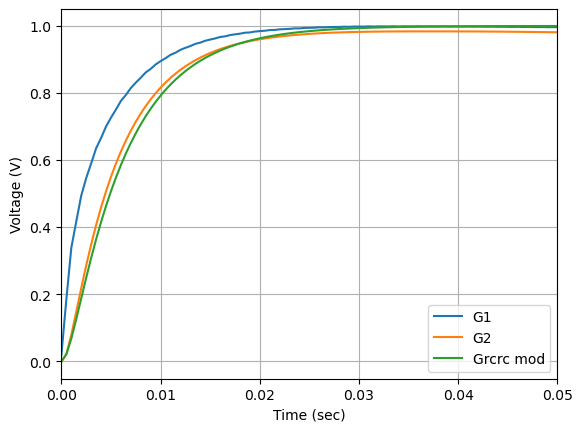

In [5]:
# Step responses
f_max = 800
step_time = np.arange(N_est) * Ts
step_resp_1 = get_step_resp_from_frd(G1, f_max)
step_resp_2 = get_step_resp_from_frd(G2, f_max)

_, step_resp_mod = ct.step_response(G_rcrc_mod, step_time)

plt.figure(4)
plt.plot(step_time, step_resp_1, label="G1")
plt.plot(step_time, step_resp_2, label="G2")
plt.plot(step_time, step_resp_mod, label="Grcrc mod")
plt.grid(True)
plt.xlabel("Time (sec)")
plt.ylabel("Voltage (V)")
plt.legend()
plt.xlim([0, 0.05])